## Processing: 4861STDY7387183
### Vic-Fabienne 12/01/2022

In [9]:
import numpy as np
import pandas as pd
import scanpy as sc
import os

In [10]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.2 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.0 python-igraph==0.9.8 pynndescent==0.5.5


In [11]:
project_dir = '/home/vfs/PycharmProjects/Organoids_sc_WS2122'
# project_dir = '../../Organoids_sc_WS2122'
results_file = os.path.join(project_dir, 'results/Tissue_4861STDY7387183.h5ad')  # the file that will store the analysis results

In [12]:
adata = sc.read_10x_mtx(
    os.path.join(project_dir, 'data/Garcia_Alonso_tissue/'),  # the directory with the `.mtx` file
    prefix='4861STDY7387183_',
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading
# be aware that the feature file is a synthetic construct - see "merging_garcia_alonso_features.rmd"

... reading from cache file cache/home-vfs-PycharmProjects-Organoids_sc_WS2122-data-Garcia_Alonso_tissue-4861STDY7387183_matrix.h5ad


Note: All files are undergoing some manual adjustment. The '_feature.tsv' files are added up to contain two columns
both (gene symbol) and from the '_cells.tsv' the header line is deleted.

In [13]:
adata.var_names_make_unique()

In [14]:
adata

AnnData object with n_obs × n_vars = 6895 × 28614
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


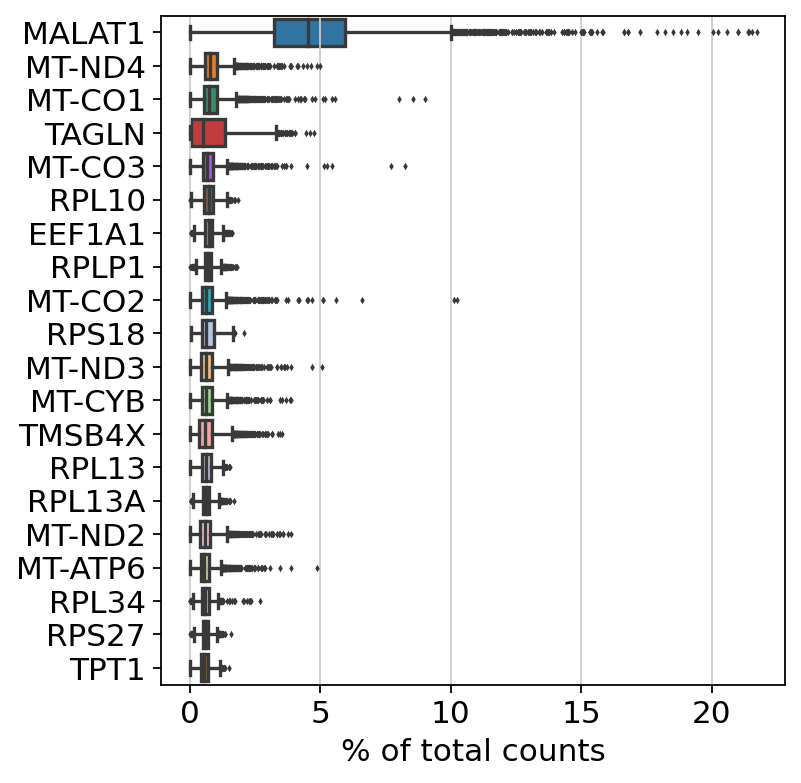

In [15]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [16]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 8930 genes that are detected in less than 3 cells


Let’s assemble some information about mitochondrial genes, which are important for quality control.
With pp.calculate_qc_metrics, we can compute many metrics very efficiently.

In [17]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

the number of genes expressed in the count matrix
the total counts per cell
the percentage of counts in mitochondrial genes

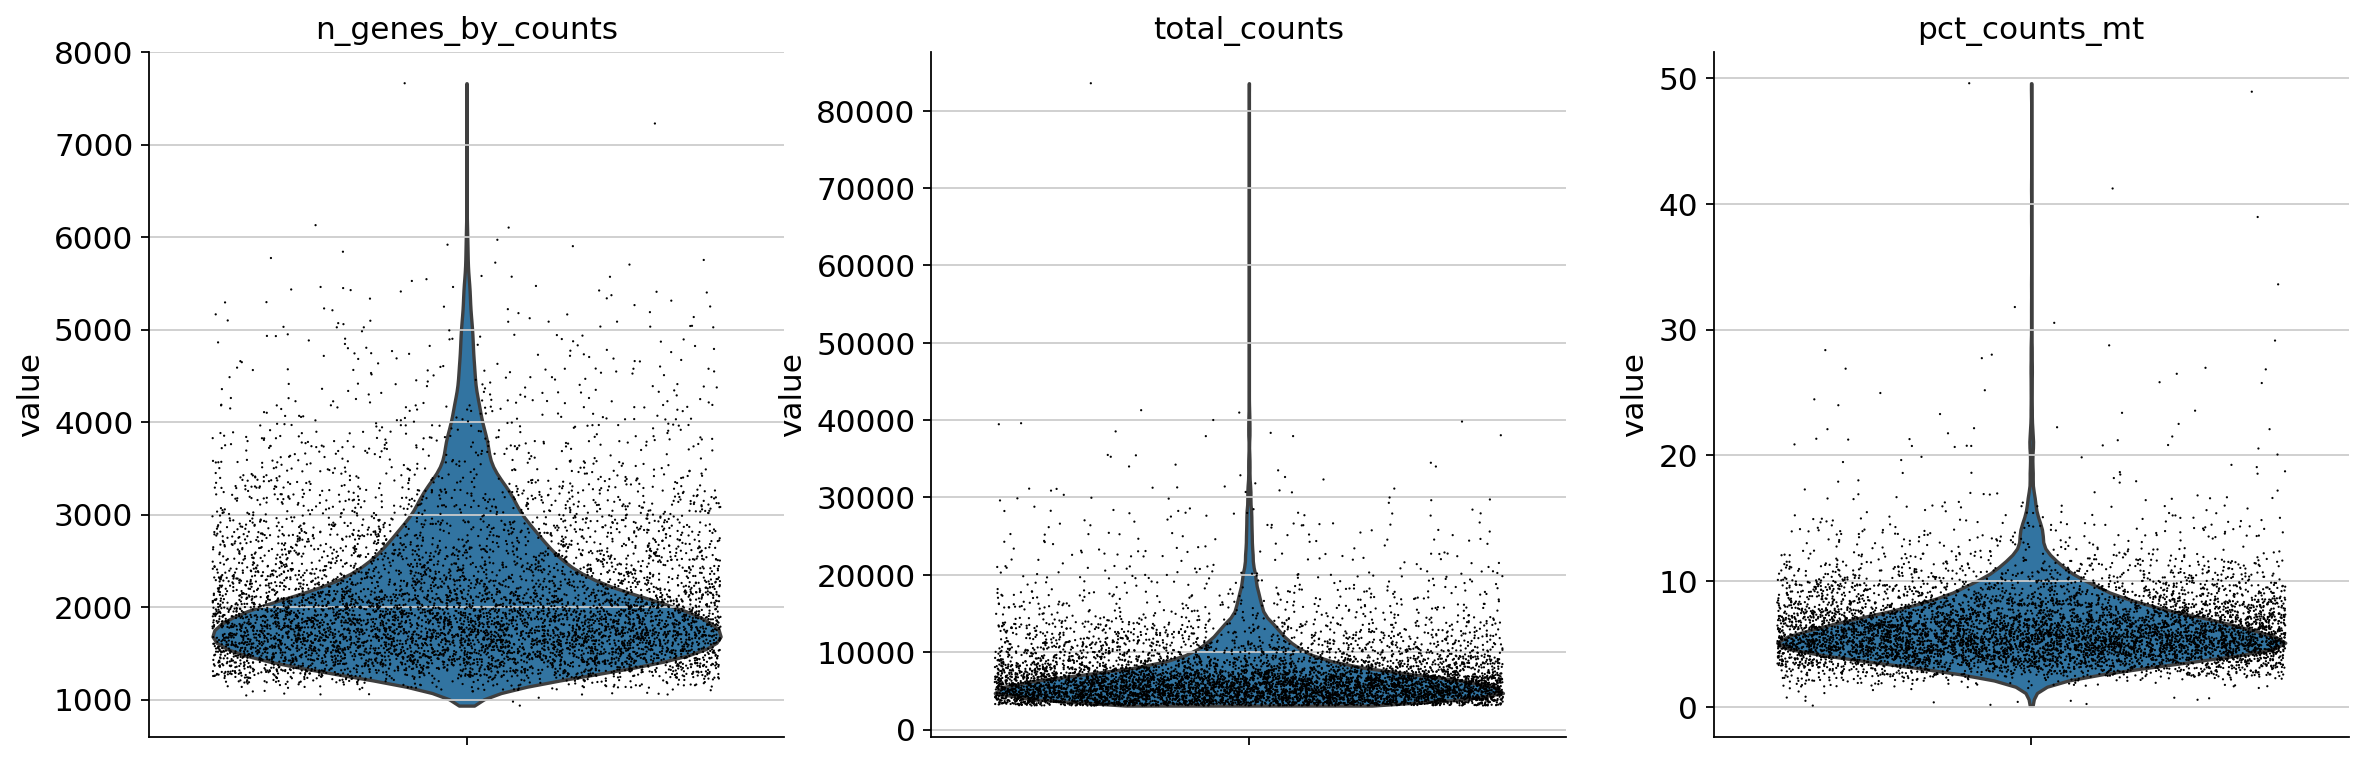

In [18]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

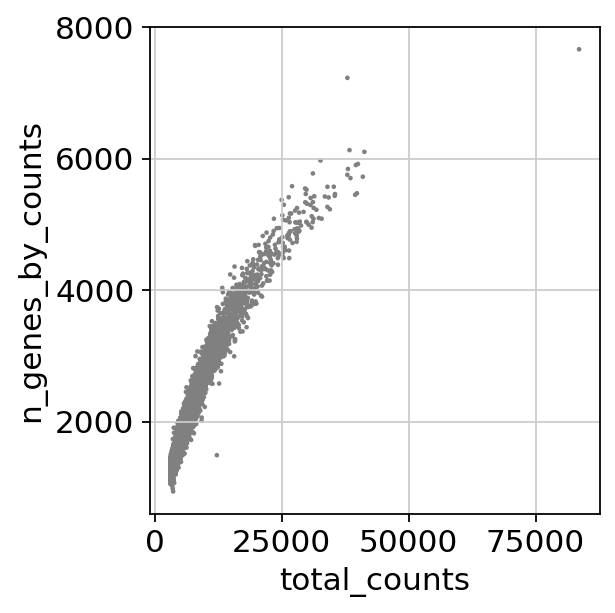

In [19]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Actually do the filtering by slicing the AnnData object.

In [20]:
adata = adata[adata.obs.n_genes_by_counts < 3000, :]
adata = adata[adata.obs.pct_counts_mt < 30, :]

Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.

In [21]:
sc.pp.normalize_total(adata, target_sum=2e4)

normalizing counts per cell
    finished (0:00:00)


/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Logarithmize the data:

In [22]:
sc.pp.log1p(adata)

Identify highly-variable genes.

In [23]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [24]:
sc.pl.highly_variable_genes(adata)

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [25]:
adata.raw = adata

Actually do the filtering

In [26]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [27]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:10)


Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [28]:
sc.pp.scale(adata, max_value=10)

Principal component analysis
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [29]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


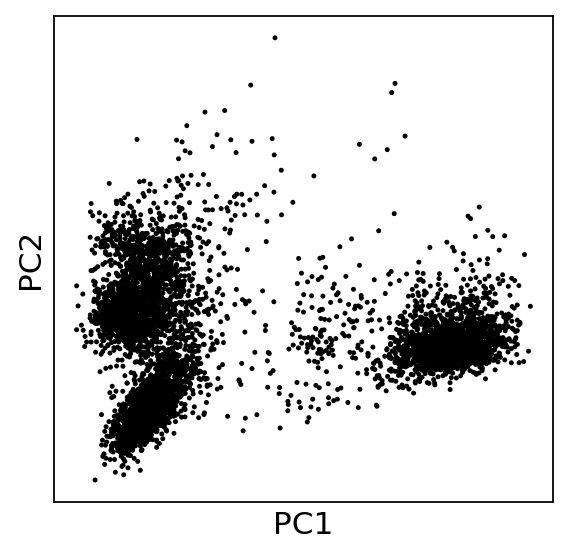

In [30]:
sc.pl.pca(adata, na_color='black')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.

In [31]:
sc.pl.pca_variance_ratio(adata, log=True)

In [32]:
adata.write(results_file)

In [33]:
adata

AnnData object with n_obs × n_vars = 5995 × 1542
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

Computing the neighborhood graph
Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.

In [48]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=25)

computing neighbors
    using 'X_pca' with n_pcs = 25
    finished (0:00:01)


Embedding the neighborhood graph
We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

In [49]:
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running Leiden clustering
    finished (0:00:00)
running PAGA
    finished (0:00:00)
computing UMAP
    finished (0:00:07)


In [50]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:07)


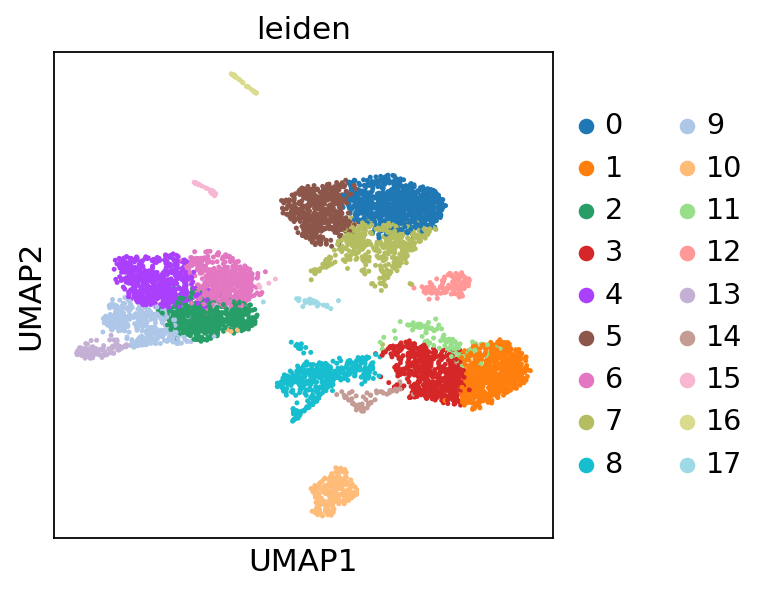

In [51]:
sc.pl.umap(adata, color = ["leiden"])

As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw.

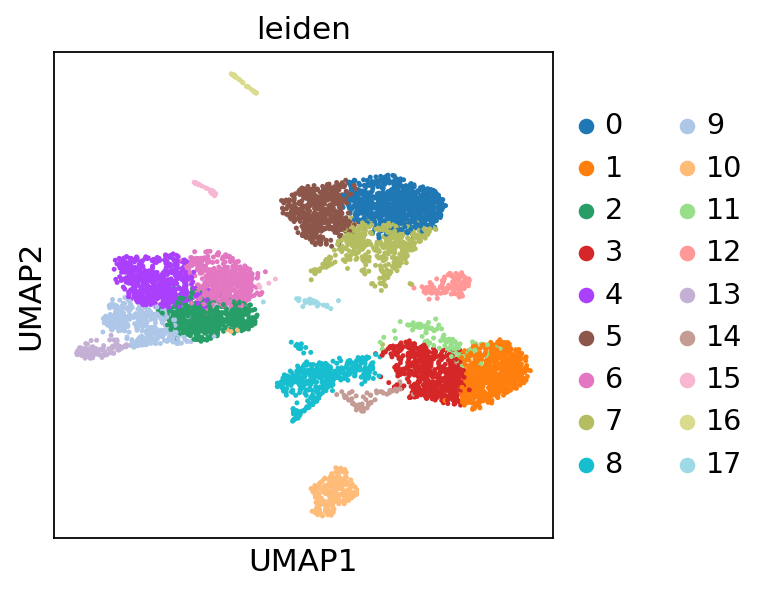

In [52]:
sc.pl.umap(adata, color=['leiden'], use_raw=False)

In [39]:
adata.write(results_file)

Finding marker genes
Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


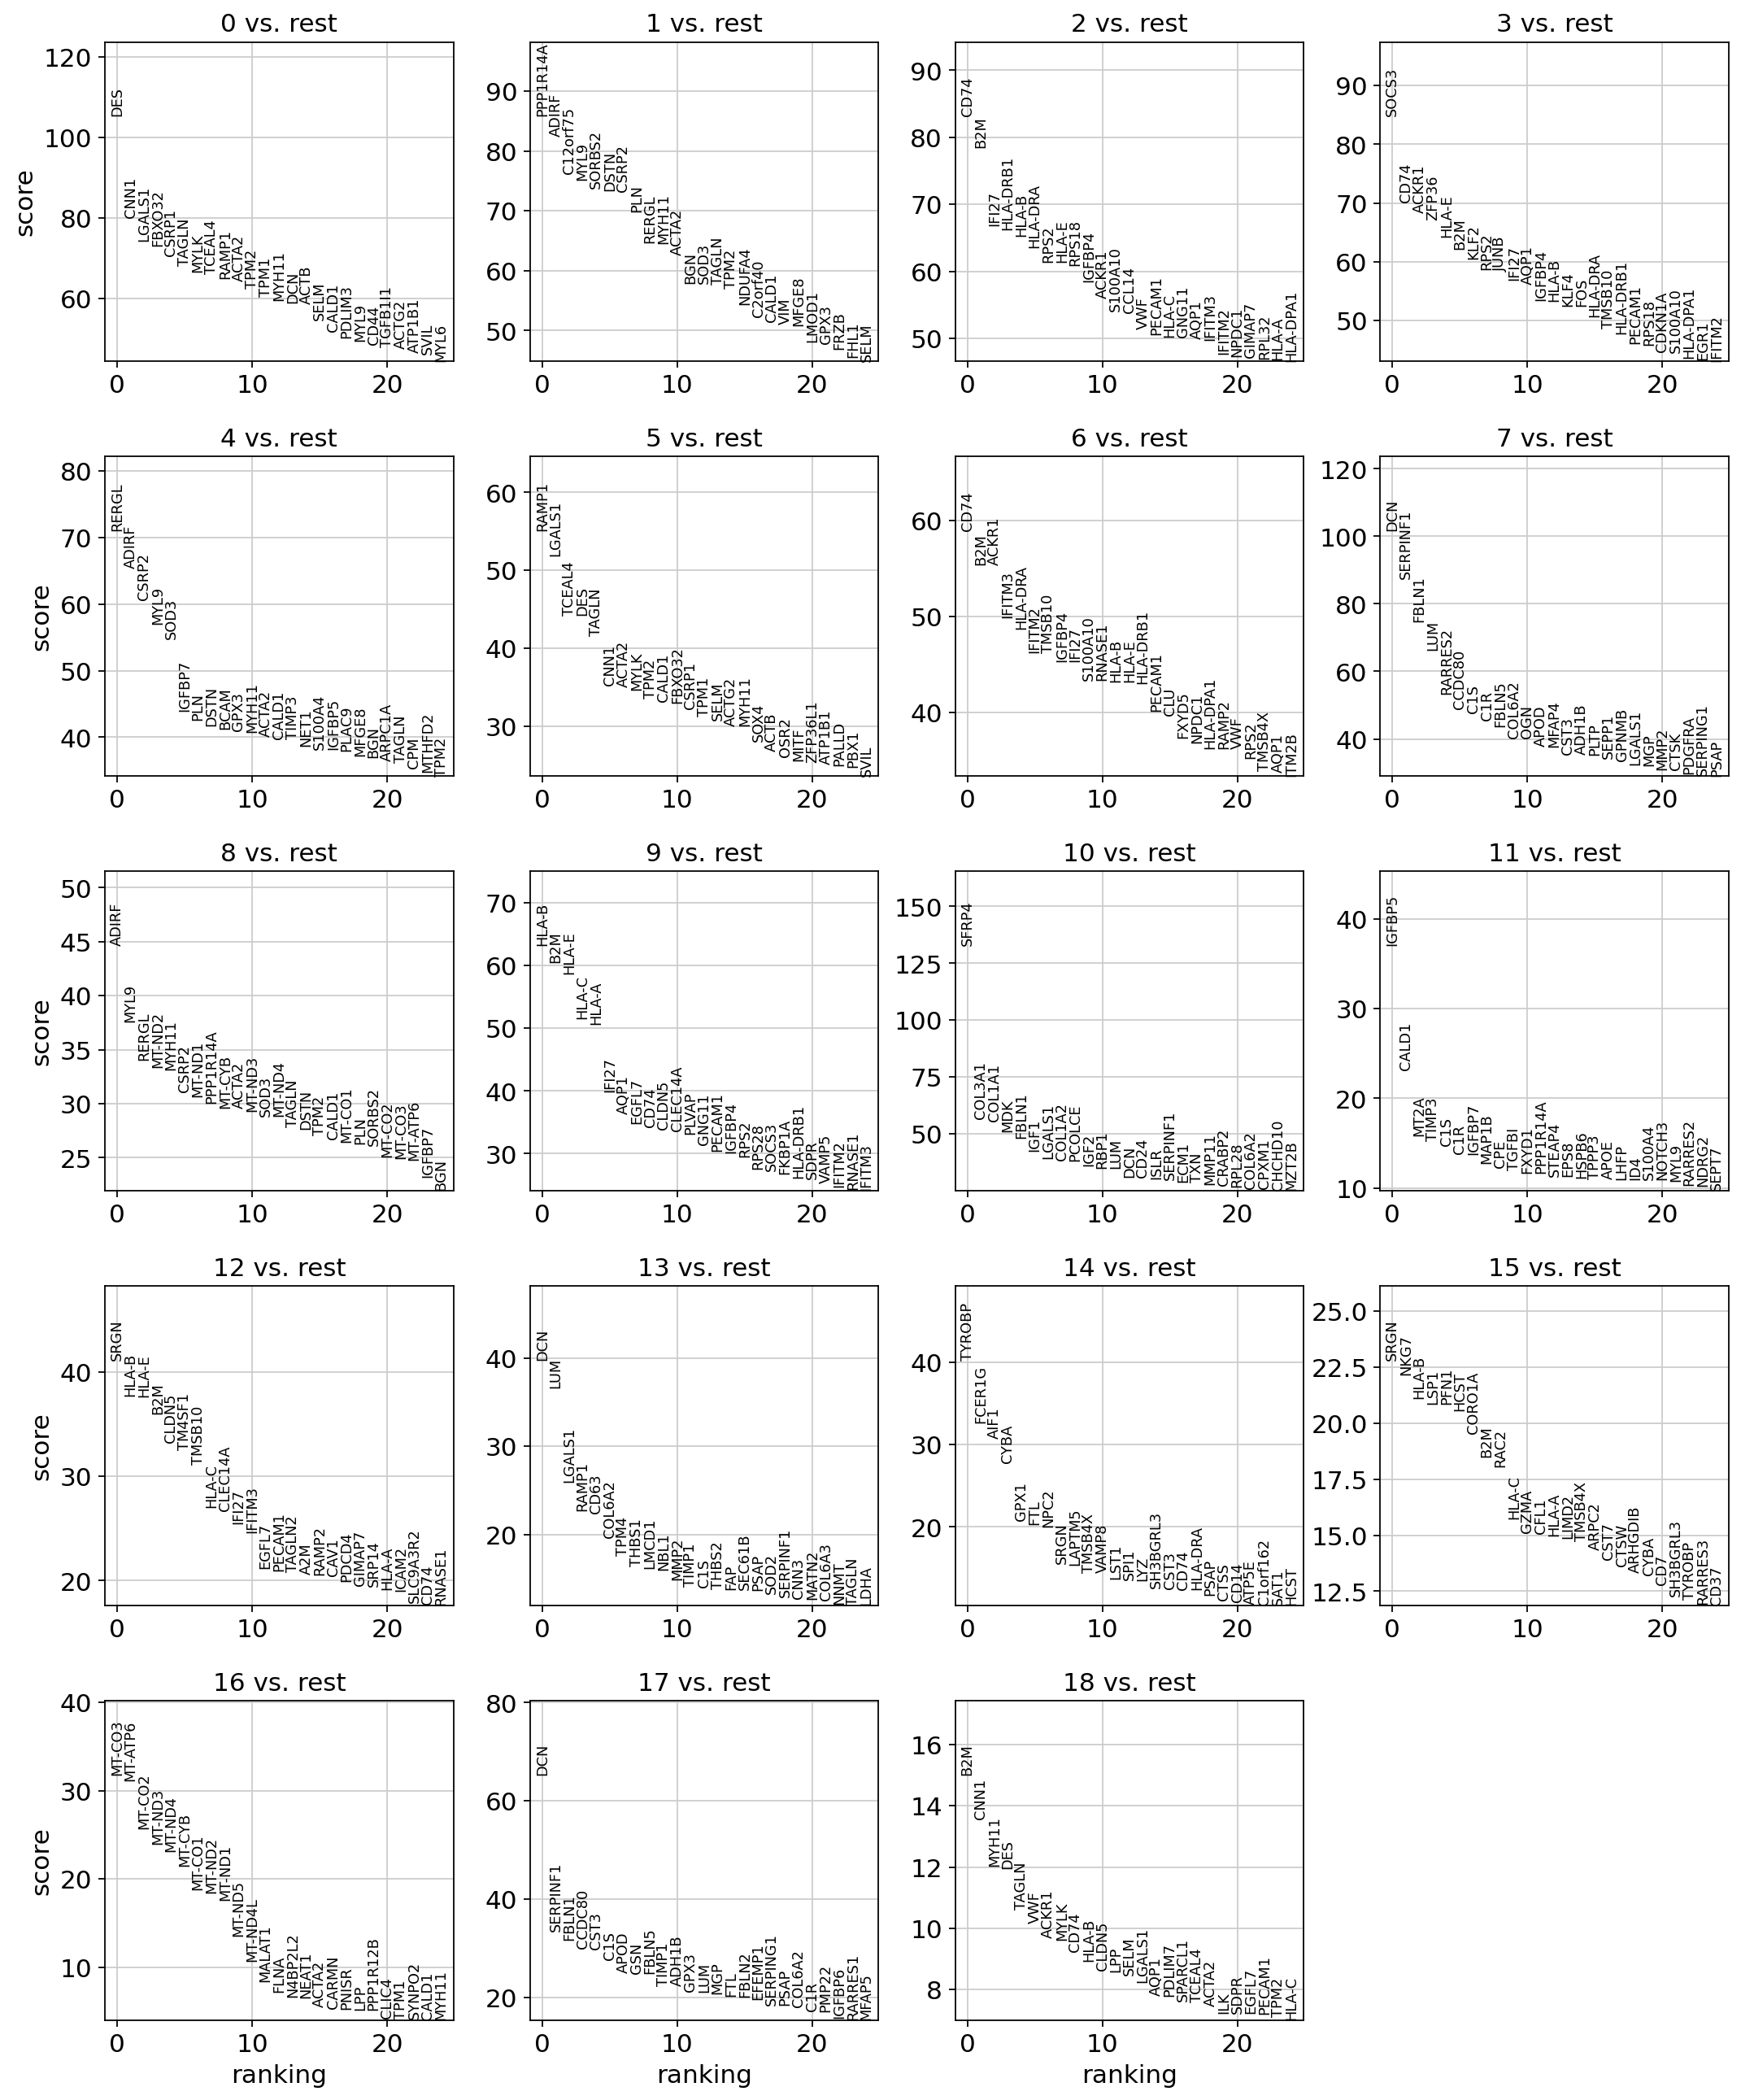

In [40]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [41]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar. We recommend using the latter in publications, see e.g., Sonison & Robinson (2018). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:08)


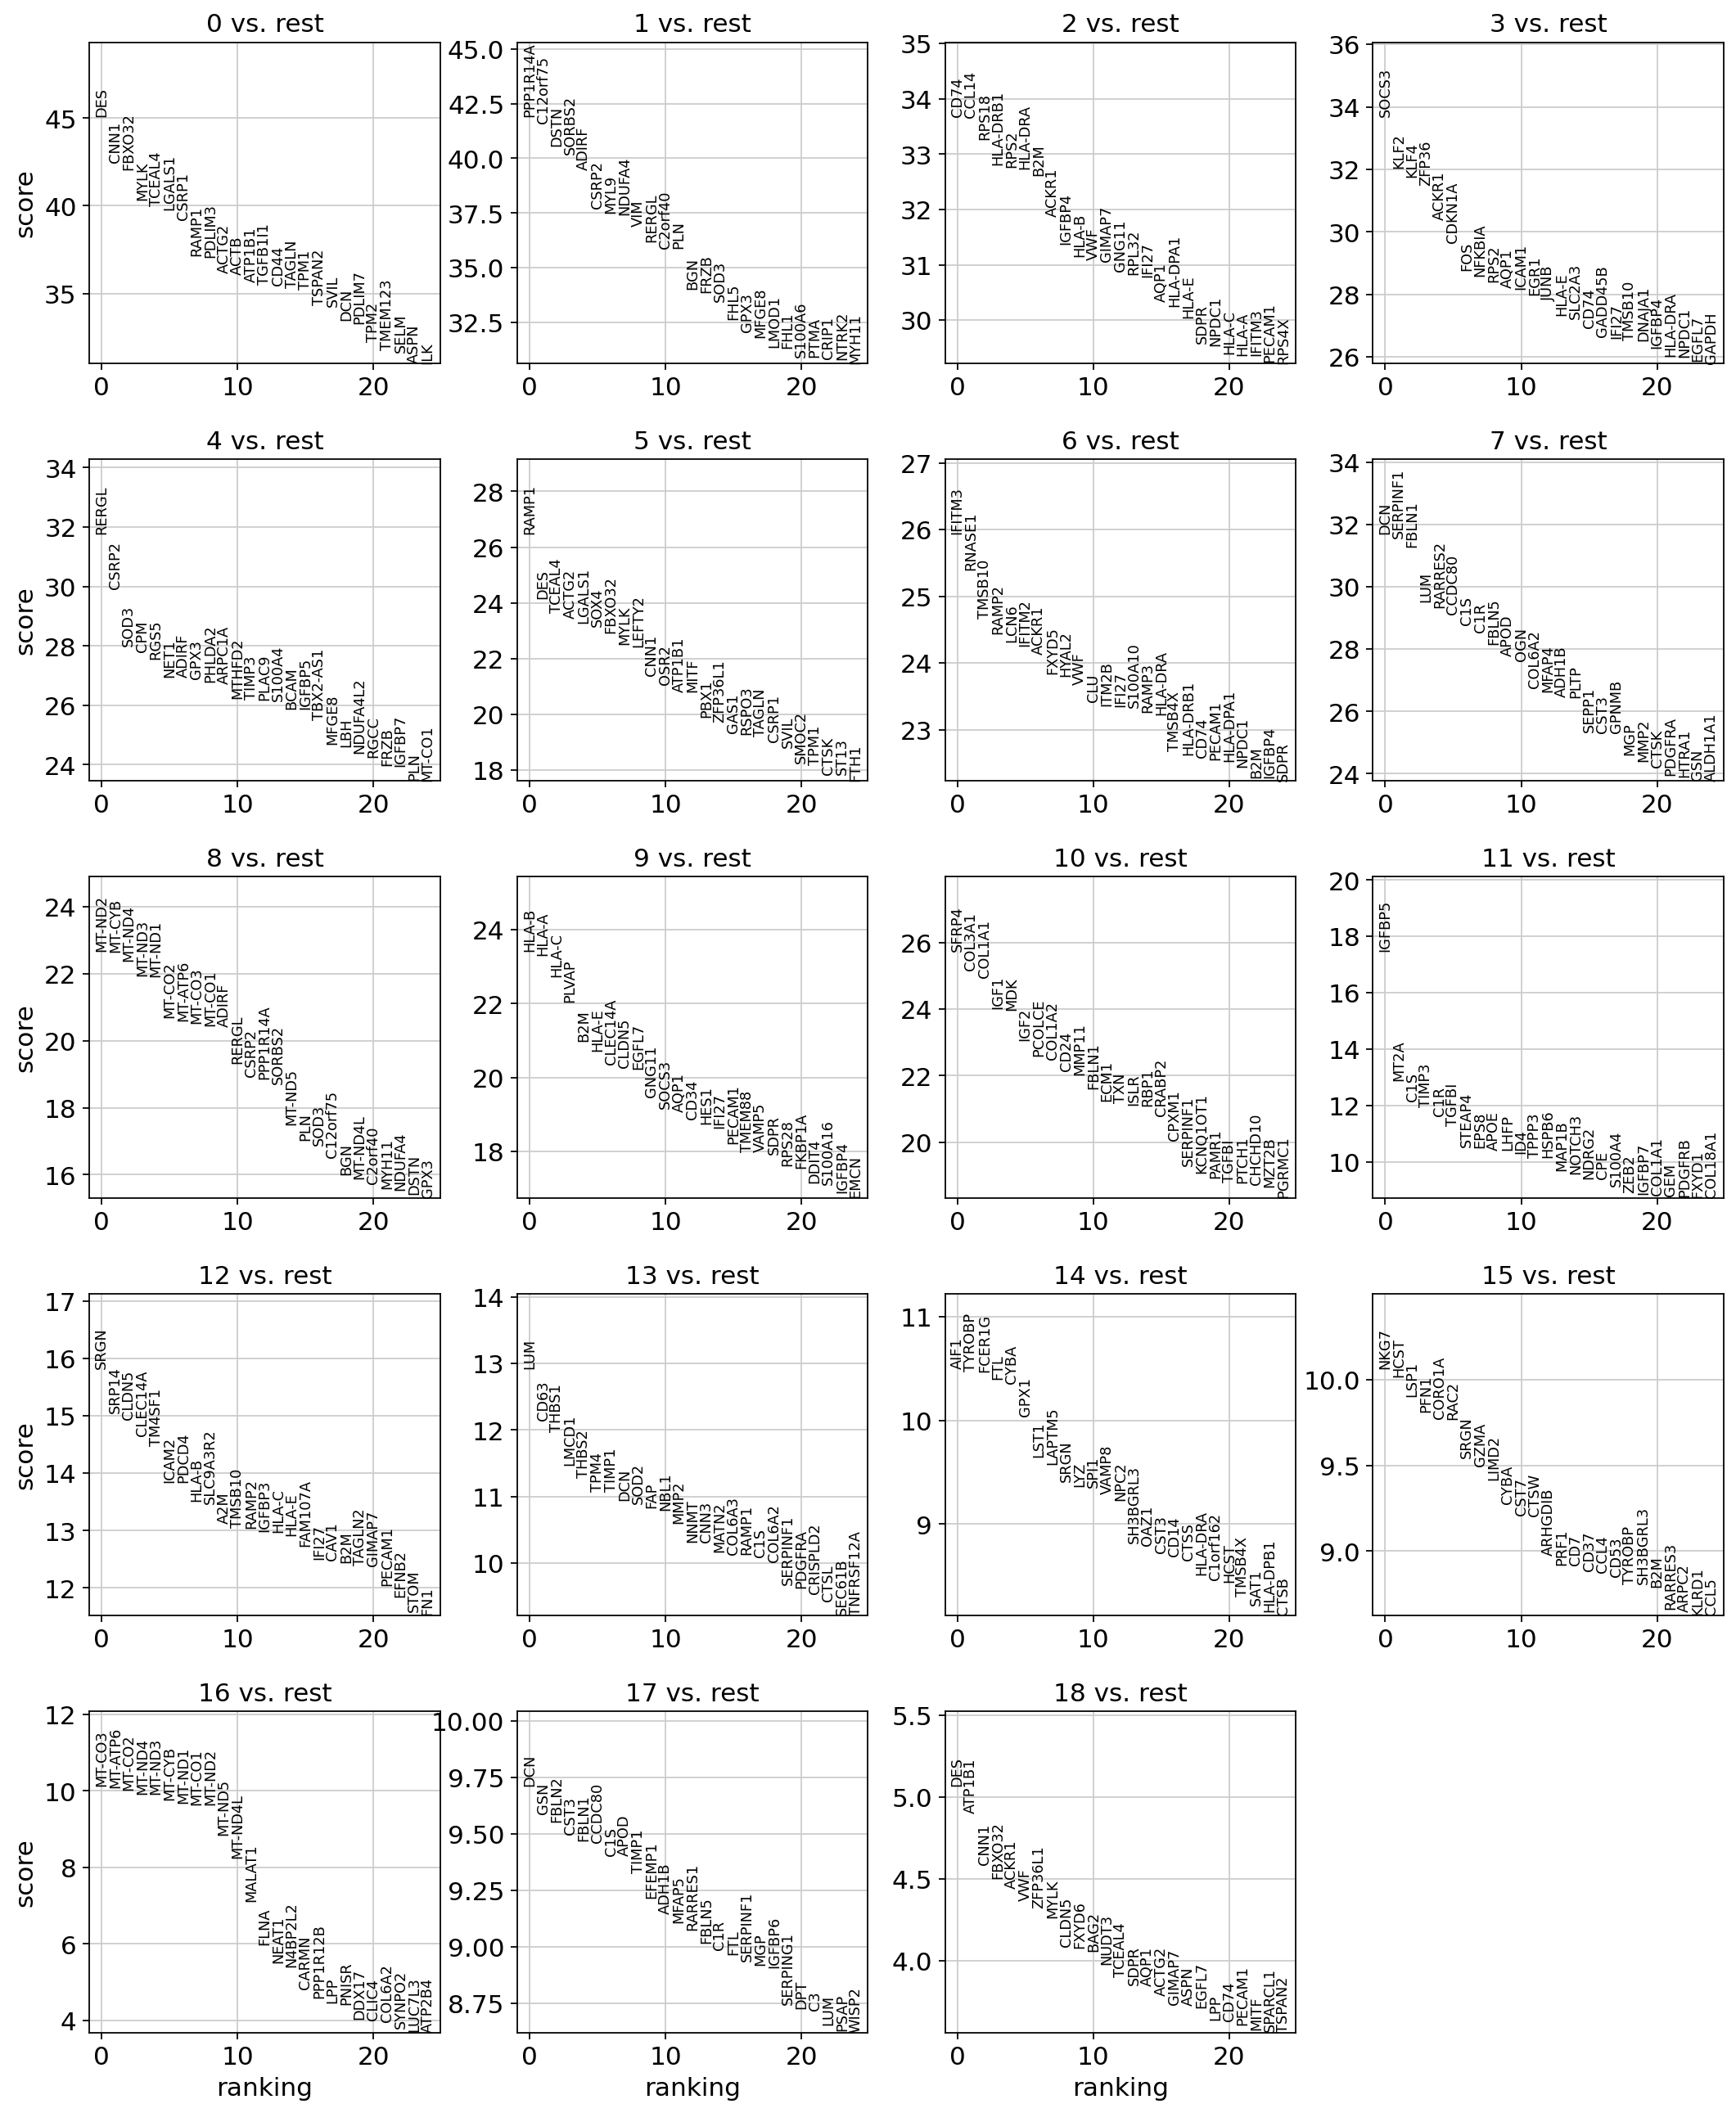

In [42]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [43]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by Natranos et al. (2018). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. Clark et al. (2014) has more details.

ranking genes
    finished (0:00:38)


/home/vfs/PycharmProjects/Organoids_sc_WS2122/scanpy/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


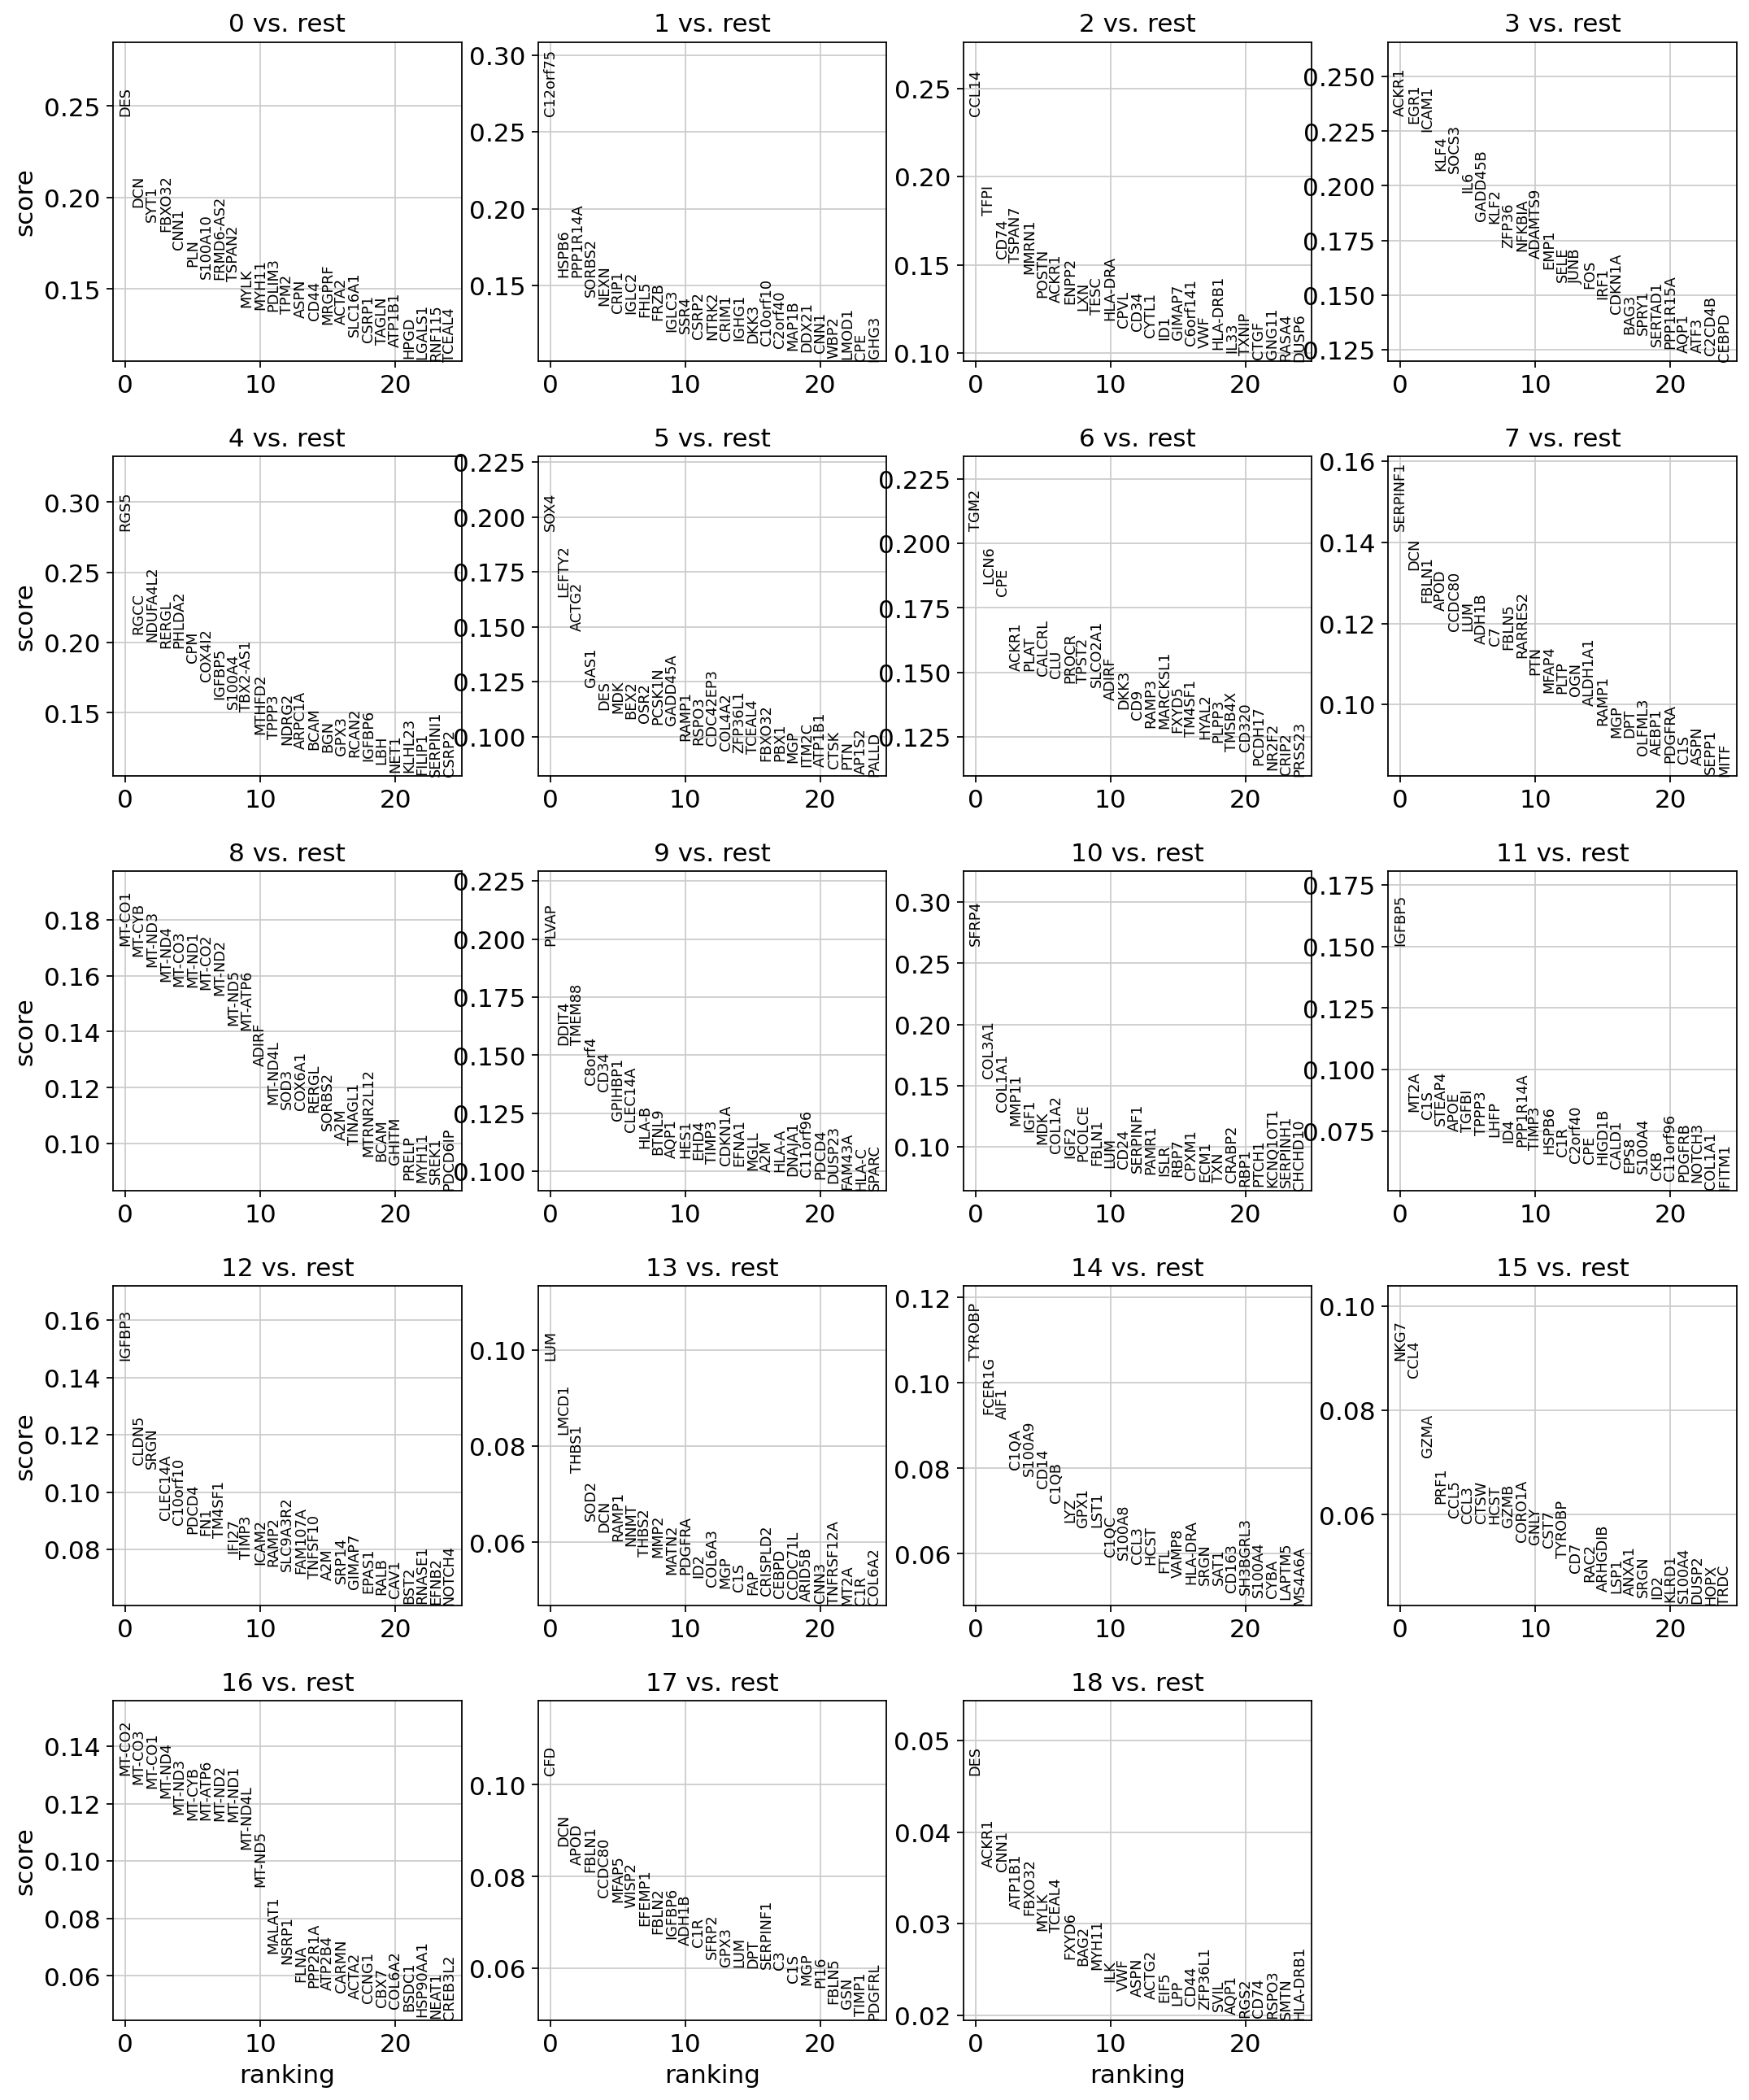

In [44]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [45]:
adata = sc.read(results_file)

In [46]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0         1         2      3      4       5       6         7       8  \
0     DES  PPP1R14A      CD74  SOCS3  RERGL   RAMP1  IFITM3       DCN  MT-ND2   
1    CNN1  C12orf75     CCL14   KLF2  CSRP2     DES  RNASE1  SERPINF1  MT-CYB   
2  FBXO32      DSTN     RPS18   KLF4   SOD3  TCEAL4  TMSB10     FBLN1  MT-ND4   
3    MYLK    SORBS2  HLA-DRB1  ZFP36    CPM   ACTG2   RAMP2       LUM  MT-ND3   
4  TCEAL4     ADIRF      RPS2  ACKR1   RGS5  LGALS1    LCN6   RARRES2  MT-ND1   

       9      10      11       12     13      14      15       16     17  \
0  HLA-B   SFRP4  IGFBP5     SRGN    LUM    AIF1    NKG7   MT-CO3    DCN   
1  HLA-A  COL3A1    MT2A    SRP14   CD63  TYROBP    HCST  MT-ATP6    GSN   
2  HLA-C  COL1A1     C1S    CLDN5  THBS1  FCER1G    LSP1   MT-CO2  FBLN2   
3  PLVAP    IGF1   TIMP3  CLEC14A  LMCD1     FTL    PFN1   MT-ND4   CST3   
4    B2M     MDK     C1R   TM4SF1  THBS2    CYBA  CORO1A   MT-ND3  FBLN1   

       18  
0     DES  
1  ATP1B1  
2    CNN1  
3  FBXO32  
4   ACKR1

In [47]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n  0_p       1_n  1_p       2_n            2_p    3_n            3_p  \
0     DES  0.0  PPP1R14A  0.0      CD74  9.712793e-249  SOCS3  6.000344e-249   
1    CNN1  0.0  C12orf75  0.0     CCL14  2.082128e-248   KLF2  2.409426e-225   
2  FBXO32  0.0      DSTN  0.0     RPS18  8.957347e-243   KLF4  2.555629e-221   
3    MYLK  0.0    SORBS2  0.0  HLA-DRB1  4.290263e-236  ZFP36  1.015115e-217   
4  TCEAL4  0.0     ADIRF  0.0      RPS2  1.522210e-235  ACKR1  6.447028e-203   

     4_n            4_p  ...    14_n          14_p    15_n          15_p  \
0  RERGL  1.168147e-221  ...    AIF1  8.471757e-26    NKG7  7.779569e-24   
1  CSRP2  6.183692e-197  ...  TYROBP  1.086798e-25    HCST  1.292008e-23   
2   SOD3  1.171039e-172  ...  FCER1G  1.258864e-25    LSP1  4.055641e-23   
3    CPM  2.410162e-170  ...     FTL  2.474938e-25    PFN1  1.021363e-22   
4   RGS5  3.534686e-167  ...    CYBA  3.967682e-25  CORO1A  1.476854e-22   

      16_n          16_p   17_n          17_p    18_n          18_p  
0   MT-CO3  3.787370e-24    DCN  2.632981e-22     DES  3.956018e-07  
1  MT-ATP6  6.069303e-24    GSN  8.985378e-22  ATP1B1  9.321571e-07  
2   MT-CO2  1.105913e-23  FBLN2  1.257135e-21    CNN1  4.508919e-06  
3   MT-ND4  3.441424e-23   CST3  2.113883e-21  FBXO32  6.639913e-06  
4   MT-ND3  3.797916e-23  FBLN1  2.771943e-21   ACKR1  8.829621e-06  

[5 rows x 38 columns]